# ML_Assignment2 - The practice of Linear Regression.
# Load Data

In [1]:
import scipy.io
import numpy as np

training = scipy.io.loadmat('TrainingDataHW2.mat')
testing = scipy.io.loadmat('TestingDataHW2.mat')
training_data = training['X_train']
training_target = training['T_train']
testing_data = testing['X_test']
testing_target = testing['T_test']

print("Training dictionary label:", training.keys())
print("Testing dictionary label:", testing.keys())
print("x1_bound: ", training['x1_bound']) 
x1_min = training['x1_bound'][0][0]
x1_max = training['x1_bound'][0][1]
print("x2_bound: ", training['x2_bound'])
x2_min = training['x2_bound'][0][0]
x2_max = training['x2_bound'][0][1]
print("X_train:", training_data)

('Training dictionary label:', ['T_train', 'X_train', 'x2_bound', '__header__', '__globals__', '__version__', 'x1_bound'])
('Testing dictionary label:', ['T_test', 'X_test', '__version__', '__header__', '__globals__'])
('x1_bound: ', array([[  0, 190]], dtype=uint8))
('x2_bound: ', array([[  0, 280]], dtype=uint16))
('X_train:', array([[140, 139,   1],
       [109, 171,   1],
       [ 66,   2,   1],
       ..., 
       [134, 198,   1],
       [167, 261,   0],
       [ 94,  31,   1]], dtype=uint16))


# Collecting Gaussian feature vector
$ϕ(x) = exp^{-\frac{(x1-ui)^2}{2s1^2}-\frac{(x2-uj)^2}{2s2^2}} , $
$ 1\leq i \leq O1, $
$ 1\leq j \leq O2 $

In [2]:
# O1, O2 is the parameter that can play with
# After trail and error, I found out that O1=5, O2=7 has the highest accuracy.
O1 = 5
O2 = 7

P = O1 * O2
s1 = float(x1_max-x1_min)/(O1-1)
s2 = float(x2_max-x2_min)/(O2-1)

def Gaussian_feature(data):
    N = data.shape[0]
    phi = np.zeros((N, P+2))
    phi[:, P+1] = np.ones(N)
    sea_indicator = data[:, 2]
    phi[:, P] = sea_indicator
    #print phi[3:6]
    x1 = data[:, 0]
    x2 = data[:, 1]

    for n in range(N):
        for i in range(1, O1+1):
            for j in range(1, O2+1):
                k = O2 * (i-1) + j
                mui = s1 * (i-1)
                muj = s2 * (j-1)
                phi[n, k-1] = np.exp( -np.square(x1[n]-mui)/(2*np.square(s1)) - \
                                      (np.square(x2[n]-muj))/(2*np.square(s2)) )

    return phi
    

phi = Gaussian_feature(training_data)
#print phi
print phi.shape


(400, 37)


## Linear Regression with Maximum Likelihood
$ \hat{WML} = (ϕ^Tϕ)^{-1} ϕ^Tt $

In [3]:
#sum of square error
def SSE(prediction, ground_truth):
    #print "SSE: ",prediction - ground_truth
    return np.sum(np.square(prediction - ground_truth))

In [4]:
# use pseudo-inverse to avoid singular matrix occur
from numpy.linalg import pinv

class maximum_likelihood():
    def __init__(self):
        self.weight = None
        
    def fit(self, phi_x, Y_train):
        phi_T = np.transpose(phi_x)
        self.weight = np.dot( np.linalg.pinv(phi_x), Y_train )        
        
        #print"phi_x:",phi_x
        print"weight shape: ",self.weight.shape
        
    def predict(self, phi_x):
        #print "WML:",self.weight
        return np.dot(phi_x, self.weight)
        
# Setup Linear Regression, fit and predict
model_1 = maximum_likelihood()
model_1.fit(phi, training_target)
ML_train_result = model_1.predict(phi)
print ML_train_result.shape
# Evaluation
ML_error = SSE(ML_train_result, training_target)
print "ML_training_error: ", ML_error

weight shape:  (37, 1)
(400, 1)
ML_training_error:  2.95222080038


## Linear Regression with Bayesian Approach
---
assume prior: $p(w) = N(w|m0 = 0, S0^{-1} = I)$
; posterior: $p(w|t) = N(w|mN=SN(S0^{-1}m0 + beta ϕ^T t), SN=(s0^{-1}+betaϕ^Tϕ)^{-1})$

In [7]:
beta = 2
class Bayesian_linear():
    def __init__(self):
        # prior
        self.m0 = np.zeros((P+2, 1))
        self.S0 = np.eye(P+2)
        self.weight = None
        #print self.S0
        
    def fit(self, phi, Y_train):
        # posterior
        phi_T = np.transpose(phi)
        S0_inv =  np.linalg.pinv(self.S0)
        sN = np.linalg.pinv( S0_inv + beta*np.dot(phi_T, phi) )
        mN = np.dot( sN, np.add(np.dot(S0_inv ,self.m0), beta*np.dot(phi_T, Y_train)) )
        self.weight = mN
        print mN.shape
        
    def predict(self, phi_x):
        return np.dot(phi_x, self.weight)
        
# Setup Bayesian Regression, fit and predict
model_2 = Bayesian_linear()
model_2.fit(phi, training_target)
Bayesian_result = model_2.predict(phi)
print Bayesian_result.shape
# Evaluation
Bayesian_error = SSE(Bayesian_result, training_target)
print "Bayesian_error: ", Bayesian_error

(37, 1)
(400, 1)
Bayesian_error:  3.89121852576


# Testing

In [8]:
print testing_data.shape
phi_test = Gaussian_feature(testing_data)
print phi_test.shape
ML_test_result = model_1.predict(phi_test)
ML_test_error = SSE(ML_test_result, testing_target)
Bayesian_test_result = model_2.predict(phi_test)
Bayesian_test_error = SSE(Bayesian_test_result, testing_target)

print ML_test_result.shape
print Bayesian_test_result.shape
print "ML_test_error:", ML_test_error, "Bayesian_test_error", Bayesian_test_error

(53200, 3)
(53200, 37)
(53200, 1)
(53200, 1)
ML_test_error: 526.06591188 Bayesian_test_error 612.861192375


# Plot
## Plot the distribution of the predicted relative humidity $y(x)$ and the squared error distribution $(y(x) − t(x))^2$ for all locations in the test data x across the United States.

In [9]:
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

In [10]:
ML_result = np.reshape(ML_test_result,(x2_max, x1_max))
Bayesian_result = np.reshape(Bayesian_test_result,(x2_max, x1_max))
target = np.reshape(testing_target, (x2_max, x1_max))

Sum of square error:

ML_test_error: 526.06591188 ; Bayesian_test_error 612.861192375


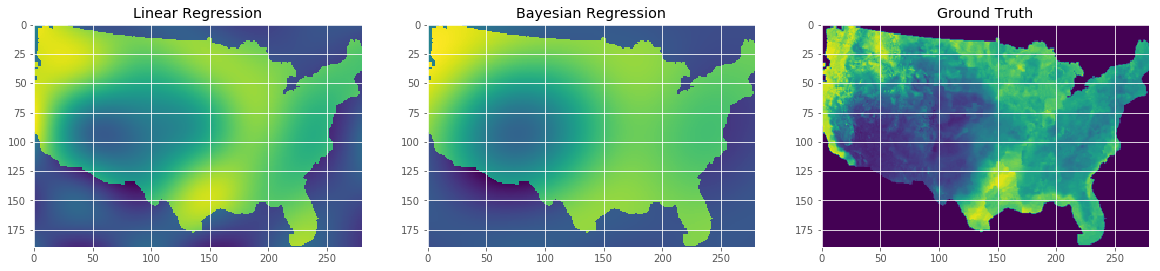

In [11]:
print "Sum of square error:\n"
print "ML_test_error:", ML_test_error, "; Bayesian_test_error", Bayesian_test_error
fig = plt.figure(figsize=(20,10))
a = fig.add_subplot(1, 3, 1)
a.set_title('Linear Regression')
plt.imshow(np.transpose(ML_result))

a = fig.add_subplot(1, 3, 2)
a.set_title('Bayesian Regression')
plt.imshow(np.transpose(Bayesian_result))

a = fig.add_subplot(1, 3, 3)
a.set_title('Ground Truth')
plt.imshow(np.transpose(target))

#plt.colorbar()

## Plot error

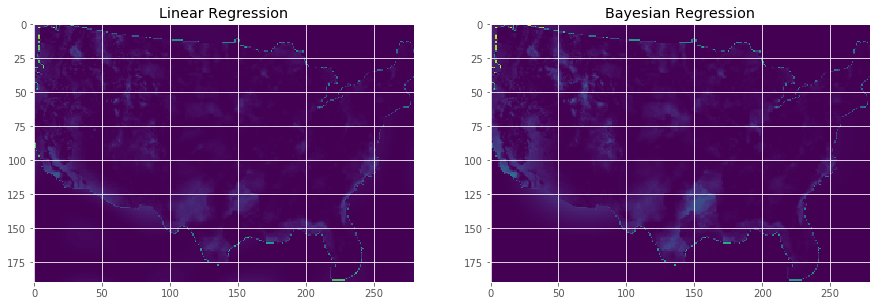

In [12]:
Error_Linear = np.transpose( np.reshape(np.square(ML_test_result-testing_target),(x2_max, x1_max)) )
Error_Bayesian = np.transpose( np.reshape(np.square(Bayesian_test_result-testing_target),(x2_max, x1_max)) )

fig = plt.figure(figsize=(15,8))
a = fig.add_subplot(1, 2, 1)
a.set_title('Linear Regression')
plt.imshow(Error_Linear)
a = fig.add_subplot(1, 2, 2)
a.set_title('Bayesian Regression')
plt.imshow(Error_Bayesian)

# Bonus
## Polynomial Regression

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X = training_data
Y = training_target
X_test = testing_data
Y_test = testing_target
print X.shape, Y.shape

(400, 3) (400, 1)


In [14]:
# PolynomialFeatures (prepreprocessing)
poly = PolynomialFeatures(degree=4)
X_ = poly.fit_transform(X)
X_test_ = poly.fit_transform(X_test)

In [15]:
# Instantiate
lg = LinearRegression()

# Fit
lg.fit(X_, Y)

# Obtain coefficients
lg.coef_.shape

(1, 35)

In [16]:
# Predict
poly_prediction = lg.predict(X_test_)
Poly_regression_error = SSE(poly_prediction, Y_test)

# Plot

Sum of square error:

Polynomial_regression_error: 604.446177054


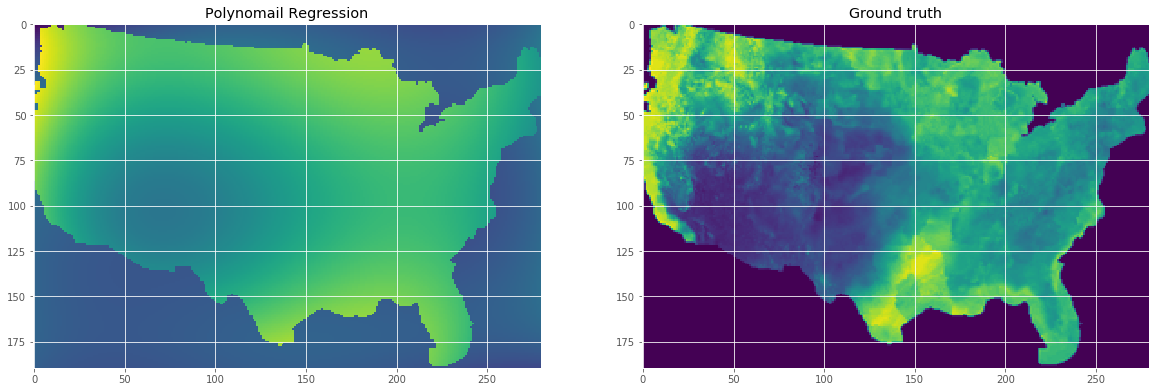

In [17]:
print "Sum of square error:\n"
print "Polynomial_regression_error:", Poly_regression_error
poly_prediction_plot = np.reshape(poly_prediction,(x2_max, x1_max))
Y_test_plot = np.reshape(Y_test,(x2_max, x1_max))

fig = plt.figure(figsize=(20,10))
a = fig.add_subplot(1, 2, 1)
a.set_title('Polynomail Regression')
plt.imshow(np.transpose(poly_prediction_plot))

a = fig.add_subplot(1, 2, 2)
a.set_title('Ground truth')
plt.imshow(np.transpose(Y_test_plot))

# Discussion and Comparison

error - ML: 526.06591188 ; Bayesian 612.861192375 ; Poly: 604.446177054


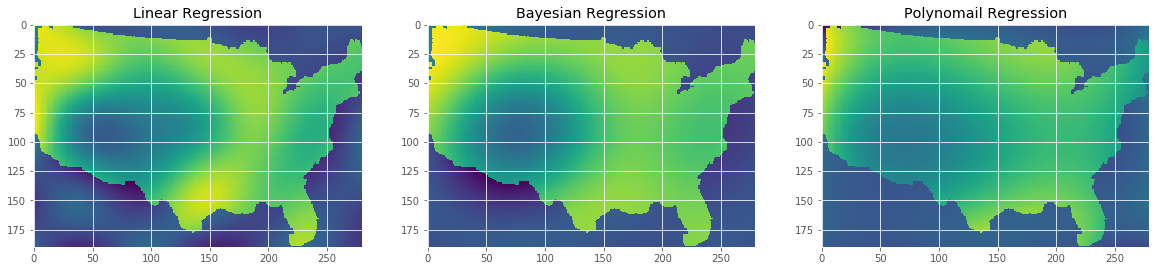

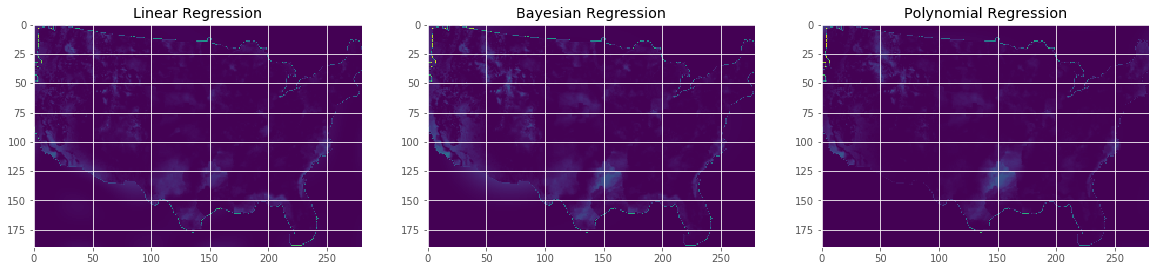

In [18]:
# Maximum Likelihood has the lowest error, while Bayesian regression has the highest error. If we adjust beta, we can find \
# that the error will also change. 
# My adaptive approach - Polynomial regression, has smaller testing error than Bayesian does.
# All statictical data the above discussions based on, is shown belowed.
fig = plt.figure(figsize=(20,10))
a = fig.add_subplot(1, 3, 1)
a.set_title('Linear Regression')
plt.imshow(np.transpose(ML_result))

a = fig.add_subplot(1, 3, 2)
a.set_title('Bayesian Regression')
plt.imshow(np.transpose(Bayesian_result))

a = fig.add_subplot(1, 3, 3)
a.set_title('Polynomail Regression')
plt.imshow(np.transpose(poly_prediction_plot))
print "error - ML:", ML_test_error, "; Bayesian", Bayesian_test_error, "; Poly:", Poly_regression_error

Error_Linear = np.transpose( np.reshape(np.square(ML_test_result-testing_target),(x2_max, x1_max)) )
Error_Bayesian = np.transpose( np.reshape(np.square(Bayesian_test_result-testing_target),(x2_max, x1_max)) )
Error_Poly = np.transpose( np.reshape(np.square(poly_prediction-testing_target),(x2_max, x1_max)) )

fig = plt.figure(figsize=(20,10))
a = fig.add_subplot(1, 3, 1)
a.set_title('Linear Regression')
plt.imshow(Error_Linear)
a = fig.add_subplot(1, 3, 2)
a.set_title('Bayesian Regression')
plt.imshow(Error_Bayesian)
a = fig.add_subplot(1, 3, 3)
a.set_title('Polynomial Regression')
plt.imshow(Error_Poly)